In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy as sc
import random
import sklearn.datasets 
import time
import pandas as pd
import seaborn as sns
import pickle as pkl
import sklearn
from sklearn.decomposition import PCA

In [2]:
'''
Partitions a dataset into a training set and a test set (80/20 split, respectively). 
Shuffles dataset before splitting. 
@param x - data inputs (numpy.ndarray)
       y - data targets (numpy.ndarray)
@return training set inputs, 
        training set targets, 
        test set inputs,
        test set targets (all numpy.ndarray)
'''
def split_train_test(x, y):
    xy = list(zip(x, y))
    random.shuffle(xy)
    x, y = zip(*xy)
    
    split = int(len(x)*0.8)
    train_x = np.array(x[:split])
    train_y = np.array(y[:split])
    test_x = np.array(x[split:])
    test_y = np.array(y[split:])
    
    train_y = np.reshape(train_y, (len(train_y),1))
    test_y = np.reshape(test_y, (len(test_y),1))
    
    return train_x, train_y, test_x, test_y

In [3]:
# importing new nan cleaned dataset:
with open('ejle_nonan_df.pkl', 'rb') as file:
    rawdata = pkl.load(file)

In [4]:
!ls 

EJSLE_mnmdstdv.pkl              EJScreen_dataprep_demoend.ipynb
EJSLE_mnmdstdv_demoend.pkl      Feature_Selection.ipynb
EJS_mnmdstdv.pkl                countyfixtest.txt
EJScreen_PCA_FFNeuralNet.ipynb  ejcounty.txt
EJScreen_PCA_finalsubmit.ipynb  ejle_nonan_df.pkl
EJScreen_dataprep.ipynb         tstmean.txt


In [5]:
# importing no demographic data:
with open('EJSLE_mnmdstdv_demoend.pkl', 'rb') as file:
    rawdata_env = pkl.load(file)

In [6]:
rawdata.columns


Index(['STATE_NAME', 'ST_ABBREV', 'CNTY_NAME', 'REGION_MEAN', 'ACSTOTPOP_MEAN',
       'VULEOPCT_MEAN', 'MINORPCT_MEAN', 'LOWINCPCT_MEAN', 'UNEMPPCT_MEAN',
       'LINGISOPCT_MEAN',
       ...
       'P_RESP_D2_STDV', 'P_PTRAF_D2_STDV', 'P_LDPNT_D2_STDV',
       'P_PNPL_D2_STDV', 'P_PRMP_D2_STDV', 'P_PTSDF_D2_STDV', 'P_UST_D2_STDV',
       'P_PWDIS_D2_STDV', 'LE_MEAN', 'LE_MEDI'],
      dtype='object', length=203)

In [7]:
rawdata_env.columns

Index(['STATE_NAME', 'ST_ABBREV', 'CNTY_NAME', 'PM25_MEAN', 'OZONE_MEAN',
       'DSLPM_MEAN', 'CANCER_MEAN', 'RESP_MEAN', 'PTRAF_MEAN',
       'PRE1960PCT_MEAN',
       ...
       'P_VULEOPCT_STDV', 'P_MINORPCT_STDV', 'P_LWINCPCT_STDV',
       'P_UNEMPPCT_STDV', 'P_LNGISPCT_STDV', 'P_LESHSPCT_STDV',
       'P_UNDR5PCT_STDV', 'P_OVR64PCT_STDV', 'LE_MEAN', 'LE_MEDI'],
      dtype='object', length=203)

In [8]:
# separating features from targets
data = rawdata.iloc[:,:-2]
lemean = rawdata.iloc[:,-2]
lemedi = rawdata.iloc[:,-1]

# ENVIRONMENTAL:
datae = rawdata_env.iloc[:,:147]
lemeane = rawdata_env.iloc[:,-2]
lemedie = rawdata_env.iloc[:,-1]

In [9]:
# convert to ndarray
data_nd = data.to_numpy()
lemean_nd = lemean.to_numpy()
lemedi_nd = lemedi.to_numpy()
datae_nd = datae.to_numpy()
lemeane_nd = lemeane.to_numpy()
lemedie_nd = lemedie.to_numpy()

In [10]:
# mean split train test + randomize
train_xme, train_yme, test_xme, test_yme = split_train_test(data_nd, lemean_nd)

# median split train test + randomize
train_xmd, train_ymd, test_xmd, test_ymd = split_train_test(data_nd, lemedi_nd)

# mean env split train test + randomize
traine_xme, traine_yme, teste_xme, teste_yme = split_train_test(datae_nd, lemeane_nd)

# median env split train test + randomize
traine_xmd, traine_ymd, teste_xmd, teste_ymd = split_train_test(datae_nd, lemedie_nd)


# PCA on EJ data 

In [11]:
# from assignment 2
def zscore_test(test, train, one=False):
    '''Function for normalizing training and test datasets using statistics of training set
    
    normalized = (raw - mean) / stddev
    
    Parameters:
        test: test dataset (ndarray)
        train: training dataset (ndarray)
    Returns:
        testz: test dataset normalized by training set statistics
        trainz: training dataset normalized'''
    
    print('Make sure training + test data do not have first column of ones')
    # calculating the mean and stddev for each column in trainz
    # will apply these to test array in another calculation for new
    # zscore
    musigma = np.zeros((2, train.shape[1]))
    musigma[0] = np.mean(train.astype(float), axis=0) # Get mean + stddev for train
    musigma[1] = np.std(train.astype(float), axis=0)
    trainz = np.zeros_like(train)
    testz = np.zeros_like(test)
    for i in range(musigma.shape[1]):
        trainz[:, i] = (train[:, i] - musigma[0, i]) / musigma[1,i]
        testz[:, i] = (test[:, i] - musigma[0,i]) / musigma[1,i] # calculate zscores
    if one:
        train_ones = np.ones((trainz.shape[0],1)) # add ones columns back
        test_ones = np.ones((testz.shape[0],1))
        trainz = np.hstack((train_ones, trainz)) 
        testz = np.hstack((test_ones, testz)) 
    return testz, trainz

In [12]:
# normalize excluding county/state names
test_xmez, train_xmez = zscore_test(test_xme[:, 3:], train_xme[:, 3:])
test_xmdz, train_xmdz = zscore_test(test_xmd[:, 3:], train_xmd[:, 3:])

teste_xmez, traine_xmez = zscore_test(teste_xme[:, 3:], traine_xme[:, 3:])
teste_xmdz, traine_xmdz = zscore_test(teste_xmd[:, 3:], traine_xmd[:, 3:])

Make sure training + test data do not have first column of ones
Make sure training + test data do not have first column of ones
Make sure training + test data do not have first column of ones
Make sure training + test data do not have first column of ones


In [13]:
# mean pca
pc_me = PCA()
# medi pca
pc_md = PCA()

# mean pca environmental
pce_me = PCA()
# medi pca environmental
pce_md = PCA()

In [14]:
# pca fit on training mean dset excluding state/county names
pc_me.fit(train_xmez)
# on median dset
pc_md.fit(train_xmdz)

# ENVIRONMENTAL:
# pca fit on training mean dset excluding state/county names
pce_me.fit(traine_xmez)
# on median dset
pce_md.fit(traine_xmdz)

PCA()

In [15]:
# cumulatively summing explained variance
cumvarme = np.cumsum(pc_me.explained_variance_ratio_)
cumvarmd = np.cumsum(pc_md.explained_variance_ratio_)

# ENVIRONMENTAL
# cumulatively summing explained variance
cumvareme = np.cumsum(pce_me.explained_variance_ratio_)
cumvaremd = np.cumsum(pce_md.explained_variance_ratio_)

In [16]:
print(np.where(cumvarme>0.95))
print(np.where(cumvarmd>0.95))

print(np.where(cumvareme>0.95))
print(np.where(cumvaremd>0.95))

(array([ 54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197]),)
(array([ 53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86, 

* Plotting cumulative explained variance vs PCs

Text(0.5, 1.0, 'Explained Variance to Principal Components')

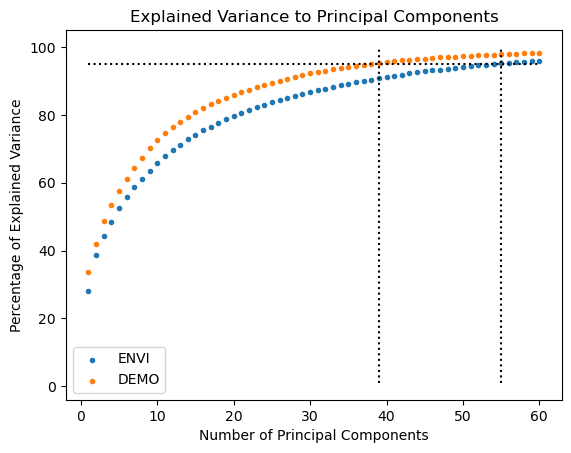

In [17]:
numpcs = 60
domain = range(1,numpcs+1)
fig0, ax0 = plt.subplots()

ax0.scatter(list(domain), cumvarme[:domain[-1]]*100, c='C0', marker='.', label='ENVI')
ax0.scatter(list(domain), cumvareme[:domain[-1]]*100, c='C1', marker='.', label='DEMO')

#ax0.scatter(list(domain), cumvarmd[:domain[-1]]*100, c='b', marker='.', label='L.E. median')
ax0.hlines(y=95, xmin=1, xmax=numpcs, linestyles='dotted', colors='k')
ax0.vlines(x=55, ymin=1, ymax=100, linestyles='dotted', colors='k')
ax0.vlines(x=39, ymin=1, ymax=100, linestyles='dotted', colors='k')

ax0.legend(loc=3)
ax0.set_xlabel('Number of Principal Components')
ax0.set_ylabel('Percentage of Explained Variance')
ax0.set_title('Explained Variance to Principal Components')